<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/001-EDA-Movement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis - Movement Branch
Extract and analyze odometry, IMU, and transform data from ROS bags

## <font color='#2E86AB'>▼ 1. Initialization and Setup</font>

In [1]:
# Install required packages
!pip install --quiet rosbags numpy matplotlib tqdm seaborn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 29.5 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import struct
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
from scipy.spatial.transform import Rotation

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore
import os
from pathlib import Path
print("ROS libraries loaded successfully!")

ROS libraries loaded successfully!


In [4]:
# Initialize typestore for ROS1 message deserialization
typestore = get_typestore(Stores.ROS1_NOETIC)
print("Typestore initialized for ROS1")

Typestore initialized for ROS1


## <font color='#2E86AB'>▼ 2. Storage Mounting</font>

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color='#2E86AB'>▼ 3. ROS Bag Load</font>

In [6]:
# Specify the path to the sessions folder
data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/"

In [7]:
# Specify the session
session = '20251016_133216'
print(f"Using session: {session}")

Using session: 20251016_133216


In [8]:
working_folder = data_path + 'session_' + session
bag_name = 'session_data.bag'

# Change to the specified subfolder
os.chdir(working_folder)
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251016_133216


In [9]:
bag_file = working_folder + '/' + bag_name
print(f"Bag file name: {bag_name}")

# Set bag_path for the rest of the notebook
bag_path = bag_file

Bag file name: session_data.bag


## <font color='#2E86AB'>▼ 4. ROS Bag Basic EDA</font>

### 1. Basic Bag Information

In [10]:
# Open the bag and get basic information
print("=" * 60)
print("BASIC BAG INFORMATION")
print("=" * 60)

with Reader(bag_path) as reader:
    # Get basic statistics
    duration = reader.duration * 1e-9  # Convert to seconds
    duration_sec = duration
    total_messages = reader.message_count

    # Get file size
    file_size_bytes = os.path.getsize(bag_path)
    file_size_mb = file_size_bytes / (1024 * 1024)

    # Calculate average message rate
    avg_message_rate = total_messages / duration if duration > 0 else 0

    print(f"\n📁 File: {bag_name}")
    print(f"💾 Size: {file_size_mb:.2f} MB")
    print(f"⏱️  Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
    print(f"📬 Total Messages: {total_messages:,}")
    print(f"📊 Average Rate: {avg_message_rate:.2f} msg/sec")

BASIC BAG INFORMATION

📁 File: session_data.bag
💾 Size: 34.35 MB
⏱️  Duration: 463.17 seconds (7.72 minutes)
📬 Total Messages: 98,205
📊 Average Rate: 212.03 msg/sec


### 2. Topic Analysis

In [11]:
# Analyze topics and connections
print("=" * 60)
print("TOPIC ANALYSIS (ROS1 BAG)")
print("=" * 60)

import struct

def parse_tf_binary(rawdata):
    """Parse TF message from raw bytes"""
    transforms = set()
    for start_offset in [0, 4, 8, 12, 16]:
        try:
            offset = start_offset
            array_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
            if array_len > 100 or array_len == 0:
                continue
            offset += 4

            for _ in range(min(array_len, 5)):
                offset += 12  # Skip seq + stamp
                str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if str_len > 100 or str_len == 0:
                    break
                offset += 4
                parent = rawdata[offset:offset+str_len].decode('utf-8', errors='ignore').strip('\\x00').strip('/')
                offset += str_len

                str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if str_len > 100 or str_len == 0:
                    break
                offset += 4
                child = rawdata[offset:offset+str_len].decode('utf-8', errors='ignore').strip('\\x00').strip('/')
                offset += str_len + 56  # Skip transform data

                if parent and child and len(parent) < 50 and len(child) < 50:
                    transforms.add(f"{parent}→{child}")
            if transforms:
                return transforms
        except:
            continue
    return transforms

# Get basic topic information with connection indices
with Reader(bag_path) as reader:
    topics_data = []
    connection_map = {}  # Store connection index mapping

    for conn_idx, connection in enumerate(reader.connections):
        topics_data.append({
            'Topic': connection.topic,
            'Message Type': connection.msgtype,
            'Count': connection.msgcount,
            'Connection_Index': conn_idx,
            'Description': ""
        })
        # Map for later use
        connection_map[conn_idx] = {'topic': connection.topic, 'msgtype': connection.msgtype, 'msgcount': connection.msgcount}

    df_topics = pd.DataFrame(topics_data)

# Analyze TF connections
print("\n🔍 Analyzing TF connections...")
with Reader(bag_path) as reader:
    tf_connection_data = {}

    for conn_idx, conn in enumerate(reader.connections):
        if conn.topic in ['/tf', '/tf_static']:
            tf_connection_data[conn_idx] = {'transforms': set(), 'samples': 0}

    for connection, timestamp, rawdata in reader.messages():
        if connection.topic in ['/tf', '/tf_static']:
            conn_idx = None
            for idx, conn in enumerate(reader.connections):
                if (conn.topic == connection.topic and
                    conn.msgtype == connection.msgtype and
                    conn.msgcount == connection.msgcount):
                    conn_idx = idx
                    break

            if conn_idx is not None and conn_idx in tf_connection_data:
                if tf_connection_data[conn_idx]['samples'] < 10:
                    try:
                        msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                        for tf in msg.transforms:
                            parent = tf.header.frame_id.strip('/')
                            child = tf.child_frame_id.strip('/')
                            tf_connection_data[conn_idx]['transforms'].add(f"{parent}→{child}")
                    except:
                        binary_transforms = parse_tf_binary(rawdata)
                        if binary_transforms:
                            tf_connection_data[conn_idx]['transforms'].update(binary_transforms)
                    tf_connection_data[conn_idx]['samples'] += 1

# Classify TF connections
for idx, row in df_topics.iterrows():
    if row['Topic'] in ['/tf', '/tf_static']:
        conn_idx = row['Connection_Index']

        if conn_idx in tf_connection_data:
            transforms = tf_connection_data[conn_idx]['transforms']

            if transforms:
                transforms_str = ', '.join(sorted(transforms)[:5])
                if len(transforms) > 5:
                    transforms_str += f" (+{len(transforms)-5} more)"

                transforms_lower = ' '.join(transforms).lower()

                if 'map' in transforms_lower and 'odom' in transforms_lower:
                    classification = "SLAM"
                elif 'odom' in transforms_lower and 'base' in transforms_lower:
                    classification = "Odometry"
                elif 'imu' in transforms_lower or 'laser' in transforms_lower or 'camera' in transforms_lower:
                    classification = "Static"
                else:
                    classification = "Other"

                df_topics.at[idx, 'Description'] = f"{classification}: {transforms_str}"
            else:
                freq = row['Count'] / duration_sec
                if freq > 40:
                    classification = "SLAM"
                elif freq > 30:
                    classification = "Odometry"
                elif freq > 15:
                    classification = "Static"
                else:
                    classification = "Other"
                df_topics.at[idx, 'Description'] = f"{classification} (by frequency)"

# Display
df_topics_display = df_topics.drop('Connection_Index', axis=1)
df_topics_display = df_topics_display.sort_values('Count', ascending=False)
df_topics_display['Frequency (Hz)'] = df_topics_display['Count'] / duration_sec

print(f"\n📊 Total Connections: {len(df_topics_display)}")
print(f"📊 Unique Topics: {df_topics_display['Topic'].nunique()}")
print(f"\n{df_topics_display.to_string(index=False)}")

df_topics_display.to_csv('topic_statistics.csv', index=False)
print(f"\n✅ Topic statistics saved to: topic_statistics.csv")

unique_topics = df_topics_display['Topic'].tolist()


TOPIC ANALYSIS (ROS1 BAG)

🔍 Analyzing TF connections...

📊 Total Connections: 13
📊 Unique Topics: 10

                          Topic                         Message Type  Count                          Description  Frequency (Hz)
                            /tf               tf2_msgs/msg/TFMessage  20459   Static: base_footprint→laser_frame       44.172132
                            /tf               tf2_msgs/msg/TFMessage  17614 Static: base_footprint→base_imu_link       38.029617
                            /tf               tf2_msgs/msg/TFMessage  16294  SLAM: map→odom, odom→base_footprint       35.179663
                       /cmd_vel              geometry_msgs/msg/Twist  11418                                            24.652104
                           /imu                  sensor_msgs/msg/Imu   9553                                            20.625464
                            /tf               tf2_msgs/msg/TFMessage   8928        Odometry: odom→base_footprint       19.2

### 3. Message Frequency Distribution

In [12]:
# Analyze message frequency distribution
print("=" * 60)
print("MESSAGE FREQUENCY DISTRIBUTION")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_timestamps = defaultdict(list)  # Track by connection index
    topic_timestamps = defaultdict(list)  # Also track by topic for backward compatibility

    print("\nCollecting timestamps...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        topic = connection.topic
        timestamp_sec = timestamp * 1e-9

        # Add to topic_timestamps
        topic_timestamps[topic].append(timestamp_sec)

        # Find connection index for detailed tracking
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_timestamps[conn_idx].append(timestamp_sec)

    print("\n📈 Inter-Message Interval Statistics (by connection):")
    print(f"{'Topic':<40} {'Description':<30} {'Mean (ms)':<12} {'Std (ms)':<12}")
    print("-" * 94)

    for conn_idx in sorted(connection_timestamps.keys()):
        timestamps = connection_timestamps[conn_idx]
        if len(timestamps) > 1:
            intervals = np.diff(timestamps) * 1000

            # Get topic info from df_topics
            topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]
            topic_name = topic_row['Topic']
            description = topic_row['Description'][:28] if topic_row['Description'] else ''

            print(f"{topic_name:<40} {description:<30} {np.mean(intervals):<12.2f} {np.std(intervals):<12.2f}")


MESSAGE FREQUENCY DISTRIBUTION



100%|██████████| 98205/98205 [00:00<00:00, 101587.19it/s]


📈 Inter-Message Interval Statistics (by connection):
Topic                                    Description                    Mean (ms)    Std (ms)    
----------------------------------------------------------------------------------------------
/csi_cam_0/camera_info                                                  59.50        500.15      
/constraint_list                                                        2766.79      10945.50    
/csi_cam_0/image_raw/compressed                                         4480.40      3405.35     
/imu                                                                    46.95        447.40      
/odom                                                                   111.79       1323.80     
/scan                                                                   1427.87      3374.64     
/tf                                      SLAM: map→odom, odom→base_fo   27.52        258.56      
/tf                                      Static: base_footprint→las

### 4. Message Size Distribution

In [13]:
# Analyze message sizes per connection
print("=" * 60)
print("MESSAGE SIZE ANALYSIS")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_sizes = defaultdict(list)

    print("\nCollecting message sizes...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        # Find connection index
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_sizes[conn_idx].append(len(rawdata))

    # Calculate statistics
    size_stats = []
    for conn_idx, sizes in connection_sizes.items():
        sizes_array = np.array(sizes)
        topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]

        size_stats.append({
            'Topic': topic_row['Topic'],
            'Description': topic_row['Description'][:40] if topic_row['Description'] else '',
            'Avg Size (bytes)': np.mean(sizes_array),
            'Total Size (MB)': np.sum(sizes_array) / (1024 * 1024)
        })

    df_sizes = pd.DataFrame(size_stats)
    df_sizes = df_sizes.sort_values('Total Size (MB)', ascending=False)

    print("\n📏 Message Size Statistics:")
    print(df_sizes.to_string(index=False))

    df_sizes.to_csv('message_size_statistics.csv', index=False)


MESSAGE SIZE ANALYSIS



100%|██████████| 98205/98205 [00:00<00:00, 110415.12it/s]



📏 Message Size Statistics:
                          Topic                          Description  Avg Size (bytes)  Total Size (MB)
/csi_cam_0/image_raw/compressed                                           35867.980000         3.420637
                           /imu                                             325.000000         2.960896
                            /tf  SLAM: map→odom, odom→base_footprint        181.000000         2.812590
                          /scan                                            9239.000000         2.775464
                          /odom                                             719.000000         2.751681
          /trajectory_node_list                                            6978.941463         2.728811
         /csi_cam_0/camera_info                                             361.000000         2.680192
                            /tf   Static: base_footprint→laser_frame        107.000000         2.087701
               /constraint_list     

## <font color='#2E86AB'>▼ 5. JetBot Movement System Hardware Documentation</font>

### Hardware Documentation: Waveshare ROS AI Kit Pro Movement System

---

## ⚙️ Motor and Encoder System

**Motors: High-Quality DC Geared Motors with Hall Encoders**

- **Type:** DC motors with carbon brushes and all-metal gear structure
- **Configuration:** Differential drive (2 motors)
- **Idle Speed:** 333 RPM
- **Encoder Type:** 11-wire AB-phase Hall speed encoder
- **Control:** PID closed-loop speed control
- **Encoder Output:** Pulses per cycle (20ms cycle time)
- **Features:** High precision, low running noise

**Wheel Parameters:**
- **Wheel Diameter:** ~65mm (typical for JetBot)
- **Wheel Base:** ~100mm (distance between wheels)
- **Wheel Circumference:** π × 0.065 ≈ 0.204m

**Odometry Calculation from Encoders:**
```
Encoding speed = pulses per 20ms cycle
Linear velocity = average of left and right encoder speeds
Angular velocity = difference between right and left speeds / wheel_base
```

---

## 📡 IMU Sensor

**IMU Chip: MPU9250 (9-Axis)**

**Specifications:**
- **Type:** 9-axis IMU
  - 3-axis Gyroscope
  - 3-axis Accelerometer  
  - 3-axis Magnetometer (compass)
- **Interface:** I2C
- **Gyroscope Range:** ±250, ±500, ±1000, ±2000 °/s
- **Accelerometer Range:** ±2g, ±4g, ±8g, ±16g
- **Sample Rate:** Typically 20-50Hz in ROS
- **Features:** High-precision 9-axis motion attitude sensor

**IMU Calibration:**
- **At startup:** LED stays ON during IMU calibration
- **After calibration:** LED flashes
- **Important:** Robot must be stationary and level during calibration
- **Recalibration:** Press RESET button if IMU data seems incorrect

---

## 🔄 Odometry Fusion

**Waveshare Uses Extended Kalman Filter (EKF) for Sensor Fusion:**

The robot uses the `robot_pose_ekf` ROS node to fuse multiple sensors:

1. **Wheel Encoder Odometry**:
   - Provides: Linear velocity, angular velocity from wheel speeds
   - Limitations: Wheel slip, uneven surfaces
   - Good for: Short-term velocity, distance estimation

2. **IMU Data** (`MPU9250`):
   - Gyroscope: Angular velocity (yaw rate)
   - Accelerometer: Linear acceleration
   - Magnetometer: Absolute heading (compass)
   - Good for: Rotation measurement, orientation

3. **Fused Odometry via EKF** (`robot_pose_ekf` node):
   - Combines encoder odometry + IMU using Extended Kalman Filter
   - Produces more accurate robot pose estimate
   - Published as TF: `odom → base_footprint`
   - Also published as `/odom` topic

**EKF Fusion Process:**
```python
# Inputs to robot_pose_ekf:
# 1. Wheel encoder odometry (position, velocity)
# 2. IMU angular velocity (gyro)
# 3. IMU linear acceleration (accel)

# EKF predicts robot state and corrects using sensor measurements
# Output: More accurate pose (x, y, yaw) and twist (vx, omega)
```

**TF Tree Structure:**
```
map (if SLAM active)
 └─ odom (published by robot_pose_ekf - EKF fused odometry)
     └─ base_footprint
         ├─ base_link
         ├─ base_imu_link (static transform)
         ├─ laser_frame (static transform)
         └─ camera_link (static transform)
```

---

## 📊 Expected ROS Topics

### 1. `/imu` Topic

**Message Type:** `sensor_msgs/Imu`

**Expected Frequency:** 20-50 Hz

**Message Structure:**
```yaml
header:
  stamp: timestamp
  frame_id: "base_imu_link"
orientation: {x, y, z, w}  # Quaternion from magnetometer/gyro integration
orientation_covariance: [9 values]
angular_velocity: {x, y, z}  # rad/s from gyroscope
angular_velocity_covariance: [9 values]
linear_acceleration: {x, y, z}  # m/s² from accelerometer
linear_acceleration_covariance: [9 values]
```

**Expected Values (stationary):**
- `angular_velocity`: ~(0, 0, 0) rad/s
- `linear_acceleration`: ~(0, 0, 9.81) m/s²
- `orientation`: Computed from magnetometer + gyro

**Expected Values (moving):**
- `angular_velocity.z`: ±0.1 to ±3.0 rad/s
- Orientation quaternion updates with rotation

---

### 2. `/odom` Topic

**Message Type:** `nav_msgs/Odometry`

**Expected Frequency:** 20-50 Hz

**Published By:** `robot_pose_ekf` node (EKF fusion)

**Message Structure:**
```yaml
header:
  stamp: timestamp
  frame_id: "odom"
child_frame_id: "base_footprint"
pose:
  pose:
    position: {x, y, z}  # meters
    orientation: {x, y, z, w}  # quaternion
  covariance: [36 values]  # from EKF
twist:
  twist:
    linear: {x, y, z}  # m/s
    angular: {x, y, z}  # rad/s
  covariance: [36 values]  # from EKF
```

---

### 3. `/cmd_vel` Topic

**Message Type:** `geometry_msgs/Twist`

**Expected Frequency:** 10-30 Hz

**Expected Values:**
- `linear.x`: -0.4 to +0.4 m/s
- `angular.z`: -2.5 to +2.5 rad/s

---

### 4. `/tf` Topics

**Multiple connections from different publishers:**

1. **Static Transforms** (~35-45 Hz):
   - `base_footprint → base_imu_link` (static, from `/base_footprint_to_imu` node)
   - `base_footprint → laser_frame` (static)
   - `base_link → camera_link` (static)

2. **Odometry Transform** (~20-40 Hz):
   - `odom → base_footprint` (from `/robot_pose_ekf` node)
   - This is the EKF-fused pose

3. **SLAM Transform** (~30-45 Hz, if SLAM active):
   - `map → odom` (from SLAM like Cartographer/Gmapping)
   - Corrects accumulated odometry drift

---

## 🔍 Data Quality Indicators

**Good Quality:**
1. LED flashing (IMU calibrated properly)
2. IMU Z-accel reads ~9.81 m/s² when stationary
3. Encoder speeds match cmd_vel commands
4. EKF covariances are reasonable (not huge)
5. Quaternions normalized (x²+y²+z²+w² = 1)

**Warning Signs:**
1. LED stays solid (IMU not calibrated - robot moving during startup)
2. IMU readings constant/zeros
3. Large timestamp gaps (>100ms)
4. Robot rotating when stationary (bad IMU calibration)
5. Odometry position jumping


## <font color='#2E86AB'>▼ 6. Movement Topic Detailed Analysis</font>

### 1. TF Transform Analysis - Static Transforms

In [14]:
# Analyze Static TF transforms
print("=" * 60)
print("STATIC TRANSFORM ANALYSIS")
print("=" * 60)

import struct

def parse_tf_binary(rawdata):
    """Parse TF message from raw bytes"""
    transforms = {}
    for start_offset in [0, 4, 8, 12, 16]:
        try:
            offset = start_offset
            array_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
            if array_len > 100 or array_len == 0:
                continue
            offset += 4

            for _ in range(min(array_len, 5)):
                offset += 12  # Skip seq + stamp
                str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if str_len > 100 or str_len == 0:
                    break
                offset += 4
                parent = rawdata[offset:offset+str_len].decode('utf-8', errors='ignore').strip('\\x00').strip('/')
                offset += str_len

                str_len = struct.unpack('<I', rawdata[offset:offset+4])[0]
                if str_len > 100 or str_len == 0:
                    break
                offset += 4
                child = rawdata[offset:offset+str_len].decode('utf-8', errors='ignore').strip('\\x00').strip('/')
                offset += str_len

                # Extract transform values
                if offset + 56 <= len(rawdata):
                    # Translation (3 doubles = 24 bytes)
                    tx, ty, tz = struct.unpack('<3d', rawdata[offset:offset+24])
                    offset += 24
                    # Rotation quaternion (4 doubles = 32 bytes)
                    qx, qy, qz, qw = struct.unpack('<4d', rawdata[offset:offset+32])
                    offset += 32

                    if parent and child and len(parent) < 50 and len(child) < 50:
                        transforms[f"{parent}→{child}"] = {
                            'parent': parent, 'child': child,
                            'tx': tx, 'ty': ty, 'tz': tz,
                            'qx': qx, 'qy': qy, 'qz': qz, 'qw': qw
                        }
            if transforms:
                return transforms
        except:
            continue
    return transforms

static_tf_data = []

with Reader(bag_path) as reader:
    # Find static TF connections
    static_conn_indices = []
    for idx, row in df_topics.iterrows():
        if row['Topic'] == '/tf' and 'Static' in str(row['Description']):
            conn_idx = row['Connection_Index']
            static_conn_indices.append(conn_idx)
            print(f"\nAnalyzing Static TF Connection #{conn_idx}")
            print(f"Description: {row['Description']}")

    # Sample messages from static transforms
    sample_count = 0
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/tf':
            # Find connection index
            conn_idx = None
            for idx, conn in enumerate(reader.connections):
                if (conn.topic == connection.topic and
                    conn.msgtype == connection.msgtype and
                    conn.msgcount == connection.msgcount):
                    conn_idx = idx
                    break

            if conn_idx in static_conn_indices:
                # Try standard deserialization first
                try:
                    msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                    for tf in msg.transforms:
                        static_tf_data.append({
                            'connection': conn_idx,
                            'parent': tf.header.frame_id.strip('/'),
                            'child': tf.child_frame_id.strip('/'),
                            'tx': tf.transform.translation.x,
                            'ty': tf.transform.translation.y,
                            'tz': tf.transform.translation.z,
                            'qx': tf.transform.rotation.x,
                            'qy': tf.transform.rotation.y,
                            'qz': tf.transform.rotation.z,
                            'qw': tf.transform.rotation.w,
                            'timestamp': timestamp * 1e-9
                        })
                        sample_count += 1
                except:
                    # Fallback to binary parsing
                    binary_transforms = parse_tf_binary(rawdata)
                    for key, tf_dict in binary_transforms.items():
                        static_tf_data.append({
                            'connection': conn_idx,
                            'parent': tf_dict['parent'],
                            'child': tf_dict['child'],
                            'tx': tf_dict['tx'],
                            'ty': tf_dict['ty'],
                            'tz': tf_dict['tz'],
                            'qx': tf_dict['qx'],
                            'qy': tf_dict['qy'],
                            'qz': tf_dict['qz'],
                            'qw': tf_dict['qw'],
                            'timestamp': timestamp * 1e-9
                        })
                        sample_count += 1

                if sample_count >= 100:
                    break

if len(static_tf_data) > 0:
    df_static_tf = pd.DataFrame(static_tf_data)

    print(f"\n🔍 Static Transform Summary:")
    print(f"Total samples: {len(df_static_tf)}")

    # Check consistency of static transforms
    for (parent, child), group in df_static_tf.groupby(['parent', 'child']):
        print(f"\n  Transform: {parent} → {child}")
        print(f"    Samples: {len(group)}")
        print(f"    Translation: ({group['tx'].mean():.4f}, {group['ty'].mean():.4f}, {group['tz'].mean():.4f})")
        print(f"    Std Dev: ({group['tx'].std():.6f}, {group['ty'].std():.6f}, {group['tz'].std():.6f})")
        print(f"    Rotation (quat): ({group['qx'].mean():.4f}, {group['qy'].mean():.4f}, {group['qz'].mean():.4f}, {group['qw'].mean():.4f})")

        # Check if truly static
        if group['tx'].std() > 0.001 or group['ty'].std() > 0.001 or group['tz'].std() > 0.001:
            print(f"    ⚠️  WARNING: Transform varies (should be static!)")
        else:
            print(f"    ✅ Transform is constant (as expected)")
else:
    print("\n⚠️  No static transforms found")

STATIC TRANSFORM ANALYSIS

Analyzing Static TF Connection #7
Description: Static: base_footprint→laser_frame

Analyzing Static TF Connection #9
Description: Static: base_footprint→base_imu_link

🔍 Static Transform Summary:
Total samples: 100

  Transform: base_footprint → base_imu_link
    Samples: 32
    Translation: (0.0000, 0.0000, 0.0700)
    Std Dev: (0.000000, 0.000000, 0.000000)
    Rotation (quat): (0.0000, 0.0000, 0.0000, 1.0000)
    ✅ Transform is constant (as expected)

  Transform: base_footprint → laser_frame
    Samples: 68
    Translation: (0.0000, 0.0000, 0.1500)
    Std Dev: (0.000000, 0.000000, 0.000000)
    Rotation (quat): (0.0000, 0.0000, 1.0000, 0.0008)
    ✅ Transform is constant (as expected)


### 2. TF Transform Analysis - Odometry Transform

ODOMETRY TRANSFORM ANALYSIS

Analyzing Odometry TF Connection #8
Description: Odometry: odom→base_footprint

🔍 Odometry Transform Summary:
Total samples: 8928
Duration: 463.04 seconds
Average rate: 19.28 Hz

📊 Position Statistics:
  X: -0.745 to 4.167 m (range: 4.912 m)
  Y: -0.338 to 3.247 m (range: 3.586 m)
  Z: 0.000 to 0.000 m (should be ~0)

📊 Orientation Statistics:
  Roll:  0.000° std (should be ~0)
  Pitch: 0.000° std (should be ~0)
  Yaw:   -180.0° to 179.9°


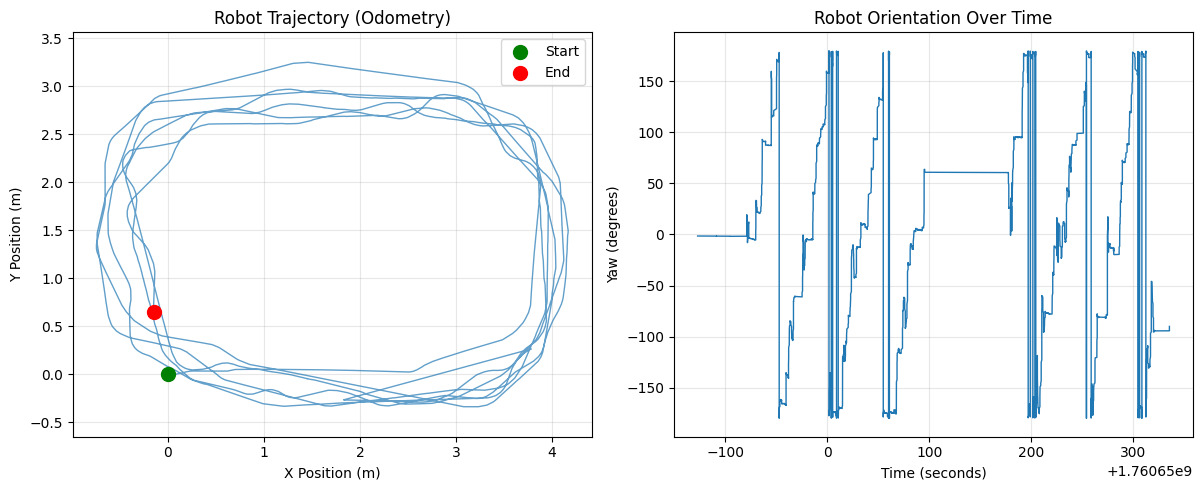


✅ Odometry transform plot saved to: odometry_tf_analysis.png


In [15]:
# Analyze Odometry TF transform
print("=" * 60)
print("ODOMETRY TRANSFORM ANALYSIS")
print("=" * 60)

odom_tf_data = []

with Reader(bag_path) as reader:
    # Find odometry TF connection
    odom_conn_idx = None
    for idx, row in df_topics.iterrows():
        if row['Topic'] == '/tf' and 'Odometry' in str(row['Description']):
            odom_conn_idx = row['Connection_Index']
            print(f"\nAnalyzing Odometry TF Connection #{odom_conn_idx}")
            print(f"Description: {row['Description']}")
            break

    if odom_conn_idx is not None:
        # Sample messages
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == '/tf':
                conn_idx = None
                for idx, conn in enumerate(reader.connections):
                    if (conn.topic == connection.topic and
                        conn.msgtype == connection.msgtype and
                        conn.msgcount == connection.msgcount):
                        conn_idx = idx
                        break

                if conn_idx == odom_conn_idx:
                    try:
                        msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                        for tf in msg.transforms:
                            parent = tf.header.frame_id.strip('/')
                            child = tf.child_frame_id.strip('/')

                            # Convert quaternion to euler angles
                            quat = [tf.transform.rotation.x, tf.transform.rotation.y,
                                   tf.transform.rotation.z, tf.transform.rotation.w]
                            rot = Rotation.from_quat(quat)
                            euler = rot.as_euler('xyz', degrees=False)

                            odom_tf_data.append({
                                'parent': parent,
                                'child': child,
                                'x': tf.transform.translation.x,
                                'y': tf.transform.translation.y,
                                'z': tf.transform.translation.z,
                                'roll': euler[0],
                                'pitch': euler[1],
                                'yaw': euler[2],
                                'timestamp': timestamp * 1e-9
                            })
                    except:
                        # Binary fallback
                        binary_transforms = parse_tf_binary(rawdata)
                        for key, tf_dict in binary_transforms.items():
                            quat = [tf_dict['qx'], tf_dict['qy'], tf_dict['qz'], tf_dict['qw']]
                            rot = Rotation.from_quat(quat)
                            euler = rot.as_euler('xyz', degrees=False)
                            odom_tf_data.append({
                                'parent': tf_dict['parent'],
                                'child': tf_dict['child'],
                                'x': tf_dict['tx'],
                                'y': tf_dict['ty'],
                                'z': tf_dict['tz'],
                                'roll': euler[0],
                                'pitch': euler[1],
                                'yaw': euler[2],
                                'timestamp': timestamp * 1e-9
                            })

if len(odom_tf_data) > 0:
    df_odom_tf = pd.DataFrame(odom_tf_data)

    print(f"\n🔍 Odometry Transform Summary:")
    print(f"Total samples: {len(df_odom_tf)}")
    print(f"Duration: {df_odom_tf['timestamp'].max() - df_odom_tf['timestamp'].min():.2f} seconds")
    print(f"Average rate: {len(df_odom_tf) / (df_odom_tf['timestamp'].max() - df_odom_tf['timestamp'].min()):.2f} Hz")

    print(f"\n📊 Position Statistics:")
    print(f"  X: {df_odom_tf['x'].min():.3f} to {df_odom_tf['x'].max():.3f} m (range: {df_odom_tf['x'].max() - df_odom_tf['x'].min():.3f} m)")
    print(f"  Y: {df_odom_tf['y'].min():.3f} to {df_odom_tf['y'].max():.3f} m (range: {df_odom_tf['y'].max() - df_odom_tf['y'].min():.3f} m)")
    print(f"  Z: {df_odom_tf['z'].min():.3f} to {df_odom_tf['z'].max():.3f} m (should be ~0)")

    print(f"\n📊 Orientation Statistics:")
    print(f"  Roll:  {np.rad2deg(df_odom_tf['roll'].std()):.3f}° std (should be ~0)")
    print(f"  Pitch: {np.rad2deg(df_odom_tf['pitch'].std()):.3f}° std (should be ~0)")
    print(f"  Yaw:   {np.rad2deg(df_odom_tf['yaw'].min()):.1f}° to {np.rad2deg(df_odom_tf['yaw'].max()):.1f}°")

    # Plot trajectory
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df_odom_tf['x'], df_odom_tf['y'], linewidth=1, alpha=0.7)
    plt.scatter(df_odom_tf['x'].iloc[0], df_odom_tf['y'].iloc[0], color='green', s=100, label='Start', zorder=5)
    plt.scatter(df_odom_tf['x'].iloc[-1], df_odom_tf['y'].iloc[-1], color='red', s=100, label='End', zorder=5)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Robot Trajectory (Odometry)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axis('equal')

    plt.subplot(1, 2, 2)
    plt.plot(df_odom_tf['timestamp'], np.rad2deg(df_odom_tf['yaw']), linewidth=1)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Yaw (degrees)')
    plt.title('Robot Orientation Over Time')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('odometry_tf_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Odometry transform plot saved to: odometry_tf_analysis.png")
else:
    print("\n⚠️  No odometry transforms found")

### 3. TF Transform Analysis - SLAM Transform

SLAM TRANSFORM ANALYSIS

Analyzing SLAM TF Connection #6
Description: SLAM: map→odom, odom→base_footprint

🔍 SLAM Transform Summary:
Total samples: 32588
Transform: map → odom

📊 SLAM Correction (Odometry Drift):
  Initial position: (-0.0000, 0.0000)
  Final position: (-0.3560, 1.6054)
  Total correction: 1.6444 m
  Initial yaw: 0.00°
  Final yaw: -126.58°
  Yaw correction: -126.58°


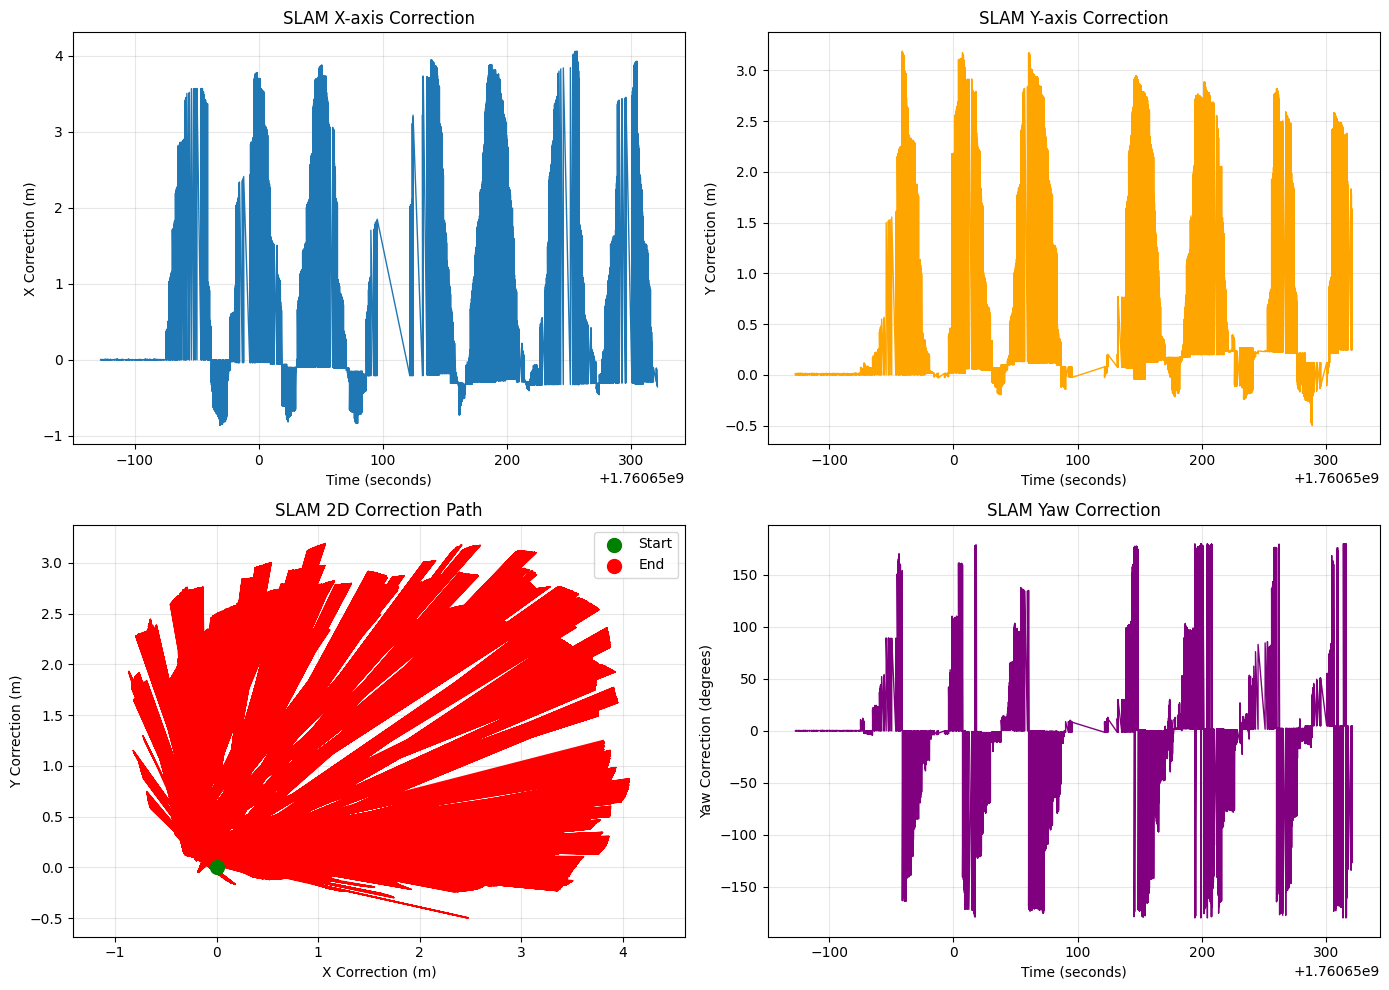


✅ SLAM transform plot saved to: slam_tf_analysis.png


In [16]:
# Analyze SLAM TF transform (map → odom)
print("=" * 60)
print("SLAM TRANSFORM ANALYSIS")
print("=" * 60)

slam_tf_data = []

with Reader(bag_path) as reader:
    # Find SLAM TF connection
    slam_conn_idx = None
    for idx, row in df_topics.iterrows():
        if row['Topic'] == '/tf' and 'SLAM' in str(row['Description']):
            slam_conn_idx = row['Connection_Index']
            print(f"\nAnalyzing SLAM TF Connection #{slam_conn_idx}")
            print(f"Description: {row['Description']}")
            break

    if slam_conn_idx is not None:
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == '/tf':
                conn_idx = None
                for idx, conn in enumerate(reader.connections):
                    if (conn.topic == connection.topic and
                        conn.msgtype == connection.msgtype and
                        conn.msgcount == connection.msgcount):
                        conn_idx = idx
                        break

                if conn_idx == slam_conn_idx:
                    try:
                        msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                        for tf in msg.transforms:
                            parent = tf.header.frame_id.strip('/')
                            child = tf.child_frame_id.strip('/')

                            quat = [tf.transform.rotation.x, tf.transform.rotation.y,
                                   tf.transform.rotation.z, tf.transform.rotation.w]
                            rot = Rotation.from_quat(quat)
                            euler = rot.as_euler('xyz', degrees=False)

                            slam_tf_data.append({
                                'parent': parent,
                                'child': child,
                                'x': tf.transform.translation.x,
                                'y': tf.transform.translation.y,
                                'yaw': euler[2],
                                'timestamp': timestamp * 1e-9
                            })
                    except:
                        # Binary fallback
                        binary_transforms = parse_tf_binary(rawdata)
                        for key, tf_dict in binary_transforms.items():
                            quat = [tf_dict['qx'], tf_dict['qy'], tf_dict['qz'], tf_dict['qw']]
                            rot = Rotation.from_quat(quat)
                            euler = rot.as_euler('xyz', degrees=False)
                            slam_tf_data.append({
                                'parent': tf_dict['parent'],
                                'child': tf_dict['child'],
                                'x': tf_dict['tx'],
                                'y': tf_dict['ty'],
                                'yaw': euler[2],
                                'timestamp': timestamp * 1e-9
                            })

if len(slam_tf_data) > 0:
    df_slam_tf = pd.DataFrame(slam_tf_data)

    print(f"\n🔍 SLAM Transform Summary:")
    print(f"Total samples: {len(df_slam_tf)}")
    print(f"Transform: {df_slam_tf['parent'].iloc[0]} → {df_slam_tf['child'].iloc[0]}")

    # Calculate drift/correction over time
    print(f"\n📊 SLAM Correction (Odometry Drift):")
    print(f"  Initial position: ({df_slam_tf['x'].iloc[0]:.4f}, {df_slam_tf['y'].iloc[0]:.4f})")
    print(f"  Final position: ({df_slam_tf['x'].iloc[-1]:.4f}, {df_slam_tf['y'].iloc[-1]:.4f})")
    print(f"  Total correction: {np.sqrt((df_slam_tf['x'].iloc[-1] - df_slam_tf['x'].iloc[0])**2 + (df_slam_tf['y'].iloc[-1] - df_slam_tf['y'].iloc[0])**2):.4f} m")
    print(f"  Initial yaw: {np.rad2deg(df_slam_tf['yaw'].iloc[0]):.2f}°")
    print(f"  Final yaw: {np.rad2deg(df_slam_tf['yaw'].iloc[-1]):.2f}°")
    print(f"  Yaw correction: {np.rad2deg(df_slam_tf['yaw'].iloc[-1] - df_slam_tf['yaw'].iloc[0]):.2f}°")

    # Plot SLAM corrections
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # X correction over time
    axes[0, 0].plot(df_slam_tf['timestamp'], df_slam_tf['x'], linewidth=1)
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('X Correction (m)')
    axes[0, 0].set_title('SLAM X-axis Correction')
    axes[0, 0].grid(True, alpha=0.3)

    # Y correction over time
    axes[0, 1].plot(df_slam_tf['timestamp'], df_slam_tf['y'], linewidth=1, color='orange')
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Y Correction (m)')
    axes[0, 1].set_title('SLAM Y-axis Correction')
    axes[0, 1].grid(True, alpha=0.3)

    # 2D correction path
    axes[1, 0].plot(df_slam_tf['x'], df_slam_tf['y'], linewidth=1, color='red')
    axes[1, 0].scatter(df_slam_tf['x'].iloc[0], df_slam_tf['y'].iloc[0], color='green', s=100, label='Start', zorder=5)
    axes[1, 0].scatter(df_slam_tf['x'].iloc[-1], df_slam_tf['y'].iloc[-1], color='red', s=100, label='End', zorder=5)
    axes[1, 0].set_xlabel('X Correction (m)')
    axes[1, 0].set_ylabel('Y Correction (m)')
    axes[1, 0].set_title('SLAM 2D Correction Path')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].axis('equal')

    # Yaw correction
    axes[1, 1].plot(df_slam_tf['timestamp'], np.rad2deg(df_slam_tf['yaw']), linewidth=1, color='purple')
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Yaw Correction (degrees)')
    axes[1, 1].set_title('SLAM Yaw Correction')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('slam_tf_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ SLAM transform plot saved to: slam_tf_analysis.png")
else:
    print("\n⚠️  No SLAM transforms found (robot may not have SLAM active)")

### 4. IMU Topic Analysis

IMU TOPIC ANALYSIS

Extracting IMU data...


98205it [00:00, 113014.45it/s]



🔍 IMU Data Summary:
Total samples: 9553
Duration: 448.50 seconds
Average rate: 21.30 Hz
Frame ID: base_imu_link

📊 Angular Velocity Statistics (rad/s):
  X (roll rate):  0.0014 ± 0.0919
  Y (pitch rate): -0.0019 ± 0.0183
  Z (yaw rate):   0.1025 ± 0.3657

📊 Linear Acceleration Statistics (m/s²):
  X: -0.0428 ± 0.1848
  Y: -0.0691 ± 0.6756
  Z: 10.2660 ± 0.6257 (expect ~9.81)

📊 Orientation Quaternion:
  Average norm: 1.000000 (should be 1.0)
  Std dev: 0.000000

📝 Sample IMU Messages:

  Sample 0 (t=0.00s):
    Angular vel (rad/s): (0.000, 0.000, 0.000)
    Linear accel (m/s²): (0.001, -0.258, 10.244)

  Sample 2388 (t=108.25s):
    Angular vel (rad/s): (0.026, 0.000, 0.022)
    Linear accel (m/s²): (-0.057, -0.106, 10.260)

  Sample 4776 (t=213.60s):
    Angular vel (rad/s): (0.061, 0.028, -0.009)
    Linear accel (m/s²): (0.176, -1.449, 11.164)

  Sample 7164 (t=342.89s):
    Angular vel (rad/s): (-0.040, 0.026, -0.862)
    Linear accel (m/s²): (0.222, 0.396, 10.601)

  Sample 9552 

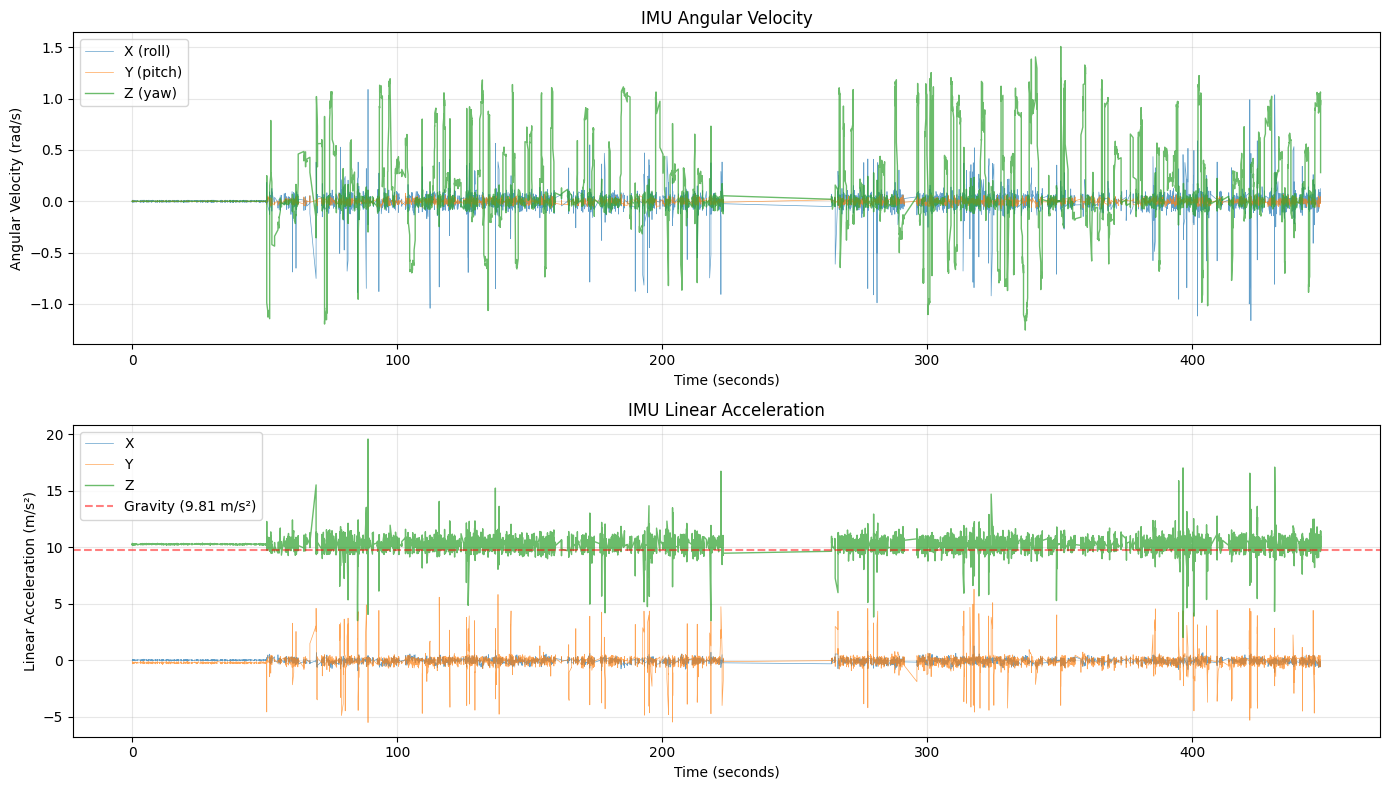


✅ IMU analysis plot saved to: imu_analysis.png


In [17]:
# Analyze IMU topic
print("=" * 60)
print("IMU TOPIC ANALYSIS")
print("=" * 60)

imu_data = []

with Reader(bag_path) as reader:
    print("\nExtracting IMU data...")
    for connection, timestamp, rawdata in tqdm(reader.messages()):
        if connection.topic == '/imu':
            try:
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                # Extract data
                imu_data.append({
                    'timestamp': timestamp * 1e-9,
                    'frame_id': msg.header.frame_id,
                    'angular_vel_x': msg.angular_velocity.x,
                    'angular_vel_y': msg.angular_velocity.y,
                    'angular_vel_z': msg.angular_velocity.z,
                    'linear_accel_x': msg.linear_acceleration.x,
                    'linear_accel_y': msg.linear_acceleration.y,
                    'linear_accel_z': msg.linear_acceleration.z,
                    'orient_x': msg.orientation.x,
                    'orient_y': msg.orientation.y,
                    'orient_z': msg.orientation.z,
                    'orient_w': msg.orientation.w
                })
            except:
                pass

if len(imu_data) > 0:
    df_imu = pd.DataFrame(imu_data)
    df_imu['timestamp'] = df_imu['timestamp'] - df_imu['timestamp'].iloc[0]  # Relative time

    print(f"\n🔍 IMU Data Summary:")
    print(f"Total samples: {len(df_imu)}")
    print(f"Duration: {df_imu['timestamp'].max():.2f} seconds")
    print(f"Average rate: {len(df_imu) / df_imu['timestamp'].max():.2f} Hz")
    print(f"Frame ID: {df_imu['frame_id'].iloc[0]}")

    print(f"\n📊 Angular Velocity Statistics (rad/s):")
    print(f"  X (roll rate):  {df_imu['angular_vel_x'].mean():.4f} ± {df_imu['angular_vel_x'].std():.4f}")
    print(f"  Y (pitch rate): {df_imu['angular_vel_y'].mean():.4f} ± {df_imu['angular_vel_y'].std():.4f}")
    print(f"  Z (yaw rate):   {df_imu['angular_vel_z'].mean():.4f} ± {df_imu['angular_vel_z'].std():.4f}")

    print(f"\n📊 Linear Acceleration Statistics (m/s²):")
    print(f"  X: {df_imu['linear_accel_x'].mean():.4f} ± {df_imu['linear_accel_x'].std():.4f}")
    print(f"  Y: {df_imu['linear_accel_y'].mean():.4f} ± {df_imu['linear_accel_y'].std():.4f}")
    print(f"  Z: {df_imu['linear_accel_z'].mean():.4f} ± {df_imu['linear_accel_z'].std():.4f} (expect ~9.81)")

    # Check orientation validity
    quat_norms = np.sqrt(df_imu['orient_x']**2 + df_imu['orient_y']**2 +
                         df_imu['orient_z']**2 + df_imu['orient_w']**2)
    print(f"\n📊 Orientation Quaternion:")
    print(f"  Average norm: {quat_norms.mean():.6f} (should be 1.0)")
    print(f"  Std dev: {quat_norms.std():.6f}")
    if quat_norms.mean() < 0.1:
        print(f"  ⚠️  WARNING: Orientation not computed (identity quaternion)")

    # Sample 5 messages
    print(f"\n📝 Sample IMU Messages:")
    sample_indices = np.linspace(0, len(df_imu)-1, 5, dtype=int)
    for idx in sample_indices:
        row = df_imu.iloc[idx]
        print(f"\n  Sample {idx} (t={row['timestamp']:.2f}s):")
        print(f"    Angular vel (rad/s): ({row['angular_vel_x']:.3f}, {row['angular_vel_y']:.3f}, {row['angular_vel_z']:.3f})")
        print(f"    Linear accel (m/s²): ({row['linear_accel_x']:.3f}, {row['linear_accel_y']:.3f}, {row['linear_accel_z']:.3f})")

    # Plot IMU data
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Angular velocity
    axes[0].plot(df_imu['timestamp'], df_imu['angular_vel_x'], label='X (roll)', alpha=0.7, linewidth=0.5)
    axes[0].plot(df_imu['timestamp'], df_imu['angular_vel_y'], label='Y (pitch)', alpha=0.7, linewidth=0.5)
    axes[0].plot(df_imu['timestamp'], df_imu['angular_vel_z'], label='Z (yaw)', alpha=0.7, linewidth=1)
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Angular Velocity (rad/s)')
    axes[0].set_title('IMU Angular Velocity')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Linear acceleration
    axes[1].plot(df_imu['timestamp'], df_imu['linear_accel_x'], label='X', alpha=0.7, linewidth=0.5)
    axes[1].plot(df_imu['timestamp'], df_imu['linear_accel_y'], label='Y', alpha=0.7, linewidth=0.5)
    axes[1].plot(df_imu['timestamp'], df_imu['linear_accel_z'], label='Z', alpha=0.7, linewidth=1)
    axes[1].axhline(y=9.81, color='red', linestyle='--', alpha=0.5, label='Gravity (9.81 m/s²)')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Linear Acceleration (m/s²)')
    axes[1].set_title('IMU Linear Acceleration')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('imu_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ IMU analysis plot saved to: imu_analysis.png")
else:
    print("\n⚠️  No IMU data found")

### 5. Odometry Topic Analysis

ODOMETRY TOPIC ANALYSIS

Extracting Odometry data...


98205it [00:01, 60804.45it/s]



⚠️  Note: /odom twist fields are zero (EKF doesn't publish velocity)
   Calculating velocities from position derivatives...
   ✅ Velocities calculated from position changes

🔍 Odometry Data Summary:
Total samples: 4013
Duration: 448.50 seconds
Average rate: 8.95 Hz
Frame: /odom → base_footprint

📊 Position Statistics:
  X: -0.745 to 4.105 m
  Y: -0.338 to 3.162 m
  Z: 0.000000 m (should be ~0)
  Total distance: 75.235 m

📊 Orientation Statistics:
  Roll:  0.000° ± 0.000°
  Pitch: 0.000° ± 0.000°
  Yaw:   -180.0° to 179.6°

📊 Velocity Statistics (calculated from position):
  Linear X:  -58.808 ± 5218.552 m/s
  Linear Y:  42.676705 m/s (should be ~0)
  Angular Z: -95.857 ± 30042.316 rad/s

📝 Sample Odometry Messages:

  Sample 0 (t=0.00s):
    Position (m): (0.000, 0.000, 0.000)
    Yaw: -1.4°
    Linear vel: 0.000 m/s, Angular vel: 0.000 rad/s

  Sample 1003 (t=87.43s):
    Position (m): (0.380, 3.003, 0.000)
    Yaw: -165.8°
    Linear vel: -185.940 m/s, Angular vel: 0.001 rad/s

  Sa

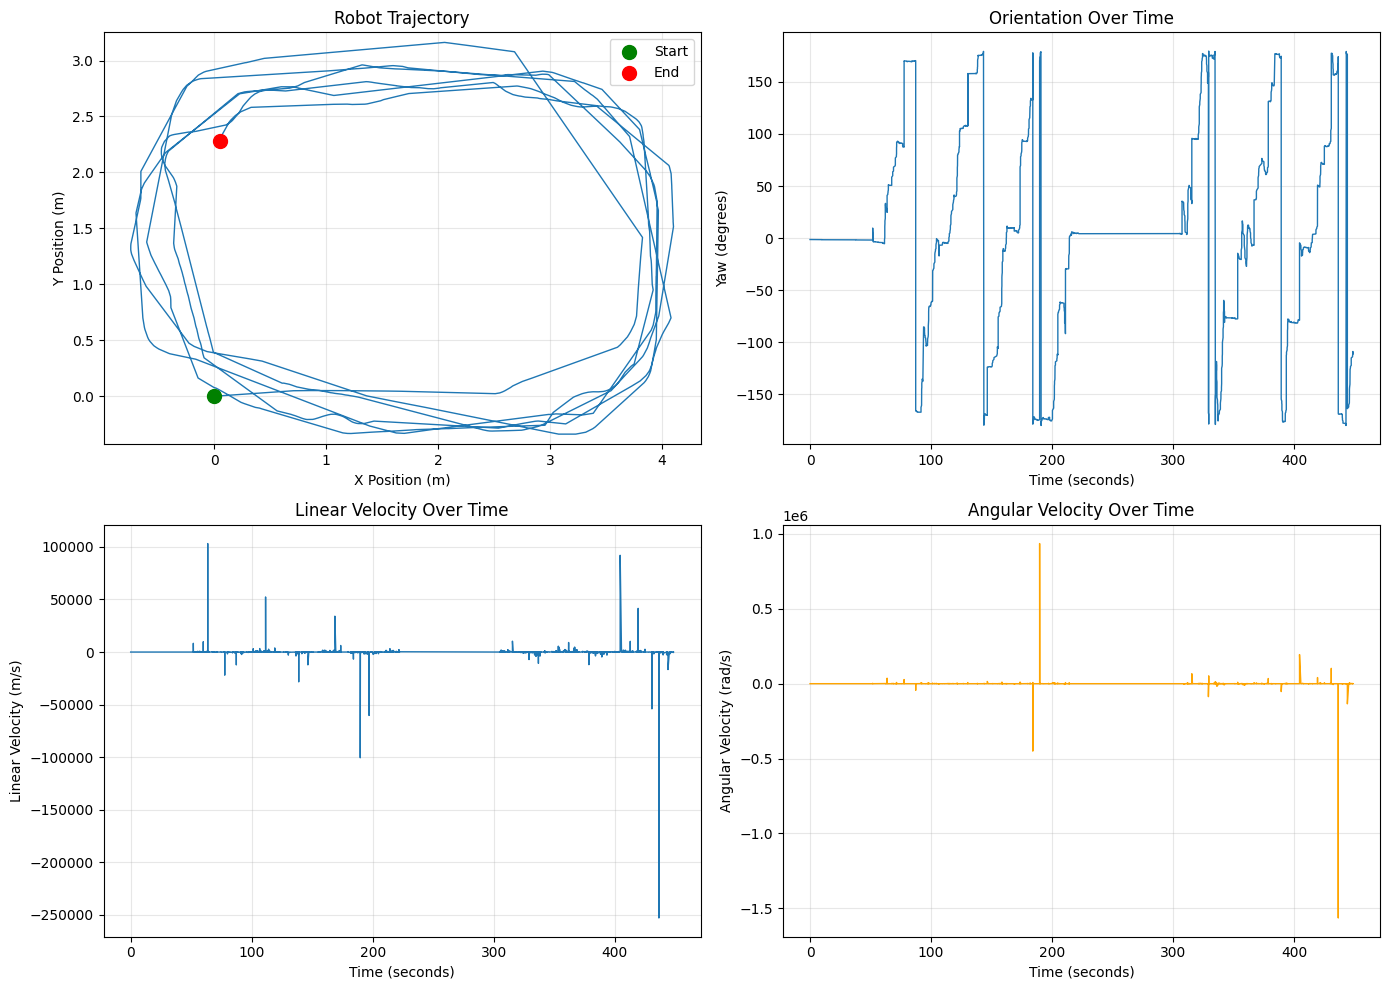


✅ Odometry analysis plot saved to: odometry_analysis.png


In [18]:
# Analyze Odometry topic
print("=" * 60)
print("ODOMETRY TOPIC ANALYSIS")
print("=" * 60)

odom_data = []

with Reader(bag_path) as reader:
    print("\nExtracting Odometry data...")
    for connection, timestamp, rawdata in tqdm(reader.messages()):
        if connection.topic == '/odom':
            try:
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                # Convert quaternion to euler
                quat = [msg.pose.pose.orientation.x, msg.pose.pose.orientation.y,
                       msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]
                rot = Rotation.from_quat(quat)
                euler = rot.as_euler('xyz', degrees=False)

                odom_data.append({
                    'timestamp': timestamp * 1e-9,
                    'frame_id': msg.header.frame_id,
                    'child_frame_id': msg.child_frame_id,
                    'pos_x': msg.pose.pose.position.x,
                    'pos_y': msg.pose.pose.position.y,
                    'pos_z': msg.pose.pose.position.z,
                    'roll': euler[0],
                    'pitch': euler[1],
                    'yaw': euler[2],
                    'vel_linear_x': msg.twist.twist.linear.x,
                    'vel_linear_y': msg.twist.twist.linear.y,
                    'vel_angular_z': msg.twist.twist.angular.z
                })
            except:
                pass

if len(odom_data) > 0:
    df_odom = pd.DataFrame(odom_data)
    df_odom['timestamp'] = df_odom['timestamp'] - df_odom['timestamp'].iloc[0]

    # Calculate velocities from position derivatives (twist fields are not populated by EKF)
    print("\n⚠️  Note: /odom twist fields are zero (EKF doesn't publish velocity)")
    print("   Calculating velocities from position derivatives...")

    if len(df_odom) > 1:
        # Time differences
        dt = df_odom['timestamp'].diff()

        # Position differences
        dx = df_odom['pos_x'].diff()
        dy = df_odom['pos_y'].diff()

        # Yaw differences
        dyaw = df_odom['yaw'].diff()

        # Calculate velocities
        df_odom['vel_linear_x_calc'] = dx / dt
        df_odom['vel_linear_y_calc'] = dy / dt
        df_odom['vel_angular_z_calc'] = dyaw / dt

        # Replace zero velocities with calculated ones
        df_odom['vel_linear_x'] = df_odom['vel_linear_x_calc'].fillna(0)
        df_odom['vel_linear_y'] = df_odom['vel_linear_y_calc'].fillna(0)
        df_odom['vel_angular_z'] = df_odom['vel_angular_z_calc'].fillna(0)

        print(f"   ✅ Velocities calculated from position changes")

    print(f"\n🔍 Odometry Data Summary:")
    print(f"Total samples: {len(df_odom)}")
    print(f"Duration: {df_odom['timestamp'].max():.2f} seconds")
    print(f"Average rate: {len(df_odom) / df_odom['timestamp'].max():.2f} Hz")
    print(f"Frame: {df_odom['frame_id'].iloc[0]} → {df_odom['child_frame_id'].iloc[0]}")

    print(f"\n📊 Position Statistics:")
    print(f"  X: {df_odom['pos_x'].min():.3f} to {df_odom['pos_x'].max():.3f} m")
    print(f"  Y: {df_odom['pos_y'].min():.3f} to {df_odom['pos_y'].max():.3f} m")
    print(f"  Z: {df_odom['pos_z'].mean():.6f} m (should be ~0)")
    distance_traveled = np.sum(np.sqrt(np.diff(df_odom['pos_x'])**2 + np.diff(df_odom['pos_y'])**2))
    print(f"  Total distance: {distance_traveled:.3f} m")

    print(f"\n📊 Orientation Statistics:")
    print(f"  Roll:  {np.rad2deg(df_odom['roll'].mean()):.3f}° ± {np.rad2deg(df_odom['roll'].std()):.3f}°")
    print(f"  Pitch: {np.rad2deg(df_odom['pitch'].mean()):.3f}° ± {np.rad2deg(df_odom['pitch'].std()):.3f}°")
    print(f"  Yaw:   {np.rad2deg(df_odom['yaw'].min()):.1f}° to {np.rad2deg(df_odom['yaw'].max()):.1f}°")

    print(f"\n📊 Velocity Statistics (calculated from position):")
    print(f"  Linear X:  {df_odom['vel_linear_x'].mean():.3f} ± {df_odom['vel_linear_x'].std():.3f} m/s")
    print(f"  Linear Y:  {df_odom['vel_linear_y'].mean():.6f} m/s (should be ~0)")
    print(f"  Angular Z: {df_odom['vel_angular_z'].mean():.3f} ± {df_odom['vel_angular_z'].std():.3f} rad/s")

    # Sample 5 messages
    print(f"\n📝 Sample Odometry Messages:")
    sample_indices = np.linspace(0, len(df_odom)-1, 5, dtype=int)
    for idx in sample_indices:
        row = df_odom.iloc[idx]
        print(f"\n  Sample {idx} (t={row['timestamp']:.2f}s):")
        print(f"    Position (m): ({row['pos_x']:.3f}, {row['pos_y']:.3f}, {row['pos_z']:.3f})")
        print(f"    Yaw: {np.rad2deg(row['yaw']):.1f}°")
        print(f"    Linear vel: {row['vel_linear_x']:.3f} m/s, Angular vel: {row['vel_angular_z']:.3f} rad/s")

    # Plot odometry
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Trajectory
    axes[0, 0].plot(df_odom['pos_x'], df_odom['pos_y'], linewidth=1)
    axes[0, 0].scatter(df_odom['pos_x'].iloc[0], df_odom['pos_y'].iloc[0], color='green', s=100, label='Start', zorder=5)
    axes[0, 0].scatter(df_odom['pos_x'].iloc[-1], df_odom['pos_y'].iloc[-1], color='red', s=100, label='End', zorder=5)
    axes[0, 0].set_xlabel('X Position (m)')
    axes[0, 0].set_ylabel('Y Position (m)')
    axes[0, 0].set_title('Robot Trajectory')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axis('equal')

    # Yaw over time
    axes[0, 1].plot(df_odom['timestamp'], np.rad2deg(df_odom['yaw']), linewidth=1)
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Yaw (degrees)')
    axes[0, 1].set_title('Orientation Over Time')
    axes[0, 1].grid(True, alpha=0.3)

    # Linear velocity
    axes[1, 0].plot(df_odom['timestamp'], df_odom['vel_linear_x'], linewidth=1)
    axes[1, 0].set_xlabel('Time (seconds)')
    axes[1, 0].set_ylabel('Linear Velocity (m/s)')
    axes[1, 0].set_title('Linear Velocity Over Time')
    axes[1, 0].grid(True, alpha=0.3)

    # Angular velocity
    axes[1, 1].plot(df_odom['timestamp'], df_odom['vel_angular_z'], linewidth=1, color='orange')
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[1, 1].set_title('Angular Velocity Over Time')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('odometry_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Odometry analysis plot saved to: odometry_analysis.png")
else:
    print("\n⚠️  No odometry data found")

### 6. Command Velocity Analysis

COMMAND VELOCITY ANALYSIS

Extracting cmd_vel data...

🔍 Command Velocity Summary:
Total commands: 11418
Duration: 417.16 seconds
Average rate: 27.37 Hz

📊 Command Statistics:
  Linear X:  0.297 ± 0.025 m/s
  Linear Y:  0.000000 m/s (should be 0)
  Angular Z: 0.170 ± 0.419 rad/s

🤖 Motion Analysis:
  Stopped: 38 commands (0.3%)
  Moving forward: 11380 commands (99.7%)
  Moving backward: 0 commands (0.0%)
  Turning: 6492 commands (56.9%)


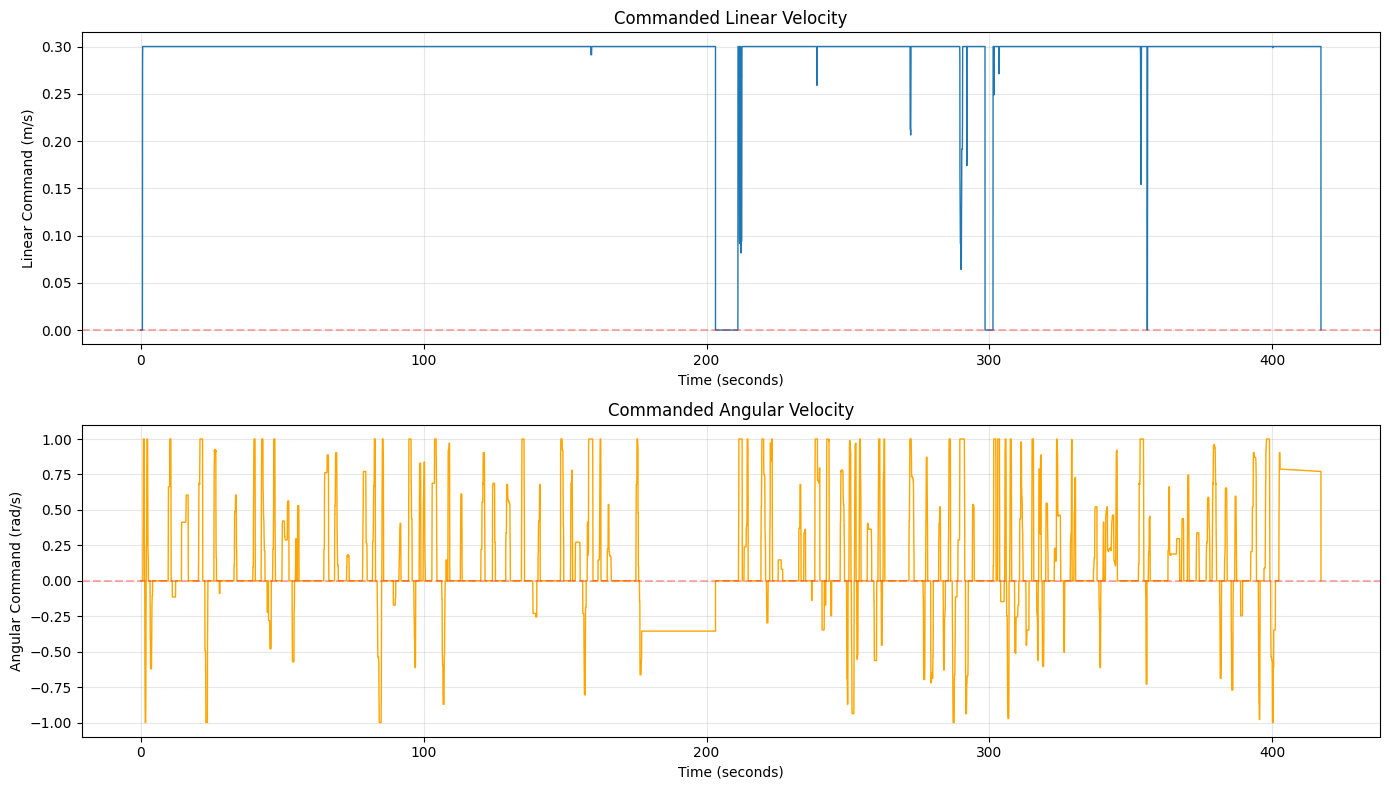


✅ Command velocity plot saved to: cmd_vel_analysis.png


In [19]:
# Analyze cmd_vel topic
print("=" * 60)
print("COMMAND VELOCITY ANALYSIS")
print("=" * 60)

cmd_vel_data = []

with Reader(bag_path) as reader:
    print("\nExtracting cmd_vel data...")
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/cmd_vel':
            try:
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
                cmd_vel_data.append({
                    'timestamp': timestamp * 1e-9,
                    'linear_x': msg.linear.x,
                    'linear_y': msg.linear.y,
                    'angular_z': msg.angular.z
                })
            except:
                pass

if len(cmd_vel_data) > 0:
    df_cmd = pd.DataFrame(cmd_vel_data)
    df_cmd['timestamp'] = df_cmd['timestamp'] - df_cmd['timestamp'].iloc[0]

    print(f"\n🔍 Command Velocity Summary:")
    print(f"Total commands: {len(df_cmd)}")
    print(f"Duration: {df_cmd['timestamp'].max():.2f} seconds")
    print(f"Average rate: {len(df_cmd) / df_cmd['timestamp'].max():.2f} Hz")

    print(f"\n📊 Command Statistics:")
    print(f"  Linear X:  {df_cmd['linear_x'].mean():.3f} ± {df_cmd['linear_x'].std():.3f} m/s")
    print(f"  Linear Y:  {df_cmd['linear_y'].mean():.6f} m/s (should be 0)")
    print(f"  Angular Z: {df_cmd['angular_z'].mean():.3f} ± {df_cmd['angular_z'].std():.3f} rad/s")

    # Detect motion phases
    stopped = (np.abs(df_cmd['linear_x']) < 0.01) & (np.abs(df_cmd['angular_z']) < 0.01)
    forward = df_cmd['linear_x'] > 0.01
    backward = df_cmd['linear_x'] < -0.01
    turning = np.abs(df_cmd['angular_z']) > 0.1

    print(f"\n🤖 Motion Analysis:")
    print(f"  Stopped: {stopped.sum()} commands ({100*stopped.sum()/len(df_cmd):.1f}%)")
    print(f"  Moving forward: {forward.sum()} commands ({100*forward.sum()/len(df_cmd):.1f}%)")
    print(f"  Moving backward: {backward.sum()} commands ({100*backward.sum()/len(df_cmd):.1f}%)")
    print(f"  Turning: {turning.sum()} commands ({100*turning.sum()/len(df_cmd):.1f}%)")

    # Plot commands
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    axes[0].plot(df_cmd['timestamp'], df_cmd['linear_x'], linewidth=1)
    axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.3)
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Linear Command (m/s)')
    axes[0].set_title('Commanded Linear Velocity')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(df_cmd['timestamp'], df_cmd['angular_z'], linewidth=1, color='orange')
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Angular Command (rad/s)')
    axes[1].set_title('Commanded Angular Velocity')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cmd_vel_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Command velocity plot saved to: cmd_vel_analysis.png")
else:
    print("\n⚠️  No cmd_vel data found")

### 7. Cross-Topic Consistency Checks

In [20]:
# Cross-topic consistency checks
print("=" * 60)
print("CROSS-TOPIC CONSISTENCY CHECKS")
print("=" * 60)

# Check 1: IMU gyro vs Odometry angular velocity
if 'df_imu' in locals() and 'df_odom' in locals():
    print("\n✓ Check 1: IMU Gyro vs Odometry Angular Velocity")
    print(f"  IMU gyro Z mean: {df_imu['angular_vel_z'].mean():.3f} rad/s")
    print(f"  Odom angular vel mean: {df_odom['vel_angular_z'].mean():.3f} rad/s")

    # Calculate correlation (requires time alignment)
    print(f"  IMU gyro Z std: {df_imu['angular_vel_z'].std():.3f} rad/s")
    print(f"  Odom angular vel std: {df_odom['vel_angular_z'].std():.3f} rad/s")

    if abs(df_imu['angular_vel_z'].mean() - df_odom['vel_angular_z'].mean()) < 0.1:
        print(f"  ✅ Angular velocities are consistent")
    else:
        print(f"  ⚠️  WARNING: Angular velocities differ significantly")
else:
    print("\n⚠️  Check 1: Cannot perform (missing IMU or Odometry data)")

# Check 2: cmd_vel vs Odometry velocity
if 'df_cmd' in locals() and 'df_odom' in locals():
    print("\n✓ Check 2: Command Velocity vs Actual Velocity")
    print(f"  Commanded linear mean: {df_cmd['linear_x'].mean():.3f} m/s")
    print(f"  Actual linear mean: {df_odom['vel_linear_x'].mean():.3f} m/s")
    print(f"  Commanded angular mean: {df_cmd['angular_z'].mean():.3f} rad/s")
    print(f"  Actual angular mean: {df_odom['vel_angular_z'].mean():.3f} rad/s")

    linear_error = abs(df_cmd['linear_x'].mean() - df_odom['vel_linear_x'].mean())
    angular_error = abs(df_cmd['angular_z'].mean() - df_odom['vel_angular_z'].mean())

    if linear_error < 0.05:
        print(f"  ✅ Linear velocity tracking is good (error: {linear_error:.3f} m/s)")
    else:
        print(f"  ⚠️  Linear velocity error: {linear_error:.3f} m/s")

    if angular_error < 0.1:
        print(f"  ✅ Angular velocity tracking is good (error: {angular_error:.3f} rad/s)")
    else:
        print(f"  ⚠️  Angular velocity error: {angular_error:.3f} rad/s")
else:
    print("\n⚠️  Check 2: Cannot perform (missing cmd_vel or Odometry data)")

# Check 3: TF odometry vs /odom topic consistency
if 'df_odom_tf' in locals() and 'df_odom' in locals():
    print("\n✓ Check 3: TF Odometry vs /odom Topic")
    print(f"  TF final position: ({df_odom_tf['x'].iloc[-1]:.3f}, {df_odom_tf['y'].iloc[-1]:.3f})")
    print(f"  /odom final position: ({df_odom['pos_x'].iloc[-1]:.3f}, {df_odom['pos_y'].iloc[-1]:.3f})")

    pos_diff = np.sqrt((df_odom_tf['x'].iloc[-1] - df_odom['pos_x'].iloc[-1])**2 +
                       (df_odom_tf['y'].iloc[-1] - df_odom['pos_y'].iloc[-1])**2)
    print(f"  Position difference: {pos_diff:.3f} m")

    if pos_diff < 0.1:
        print(f"  ✅ TF and /odom are consistent")
    else:
        print(f"  ⚠️  WARNING: TF and /odom differ by {pos_diff:.3f} m")
else:
    print("\n⚠️  Check 3: Cannot perform (missing TF or /odom data)")

# Check 4: IMU acceleration Z-axis (gravity check)
if 'df_imu' in locals():
    print("\n✓ Check 4: IMU Gravity Reading")
    gravity = df_imu['linear_accel_z'].mean()
    print(f"  Measured gravity: {gravity:.3f} m/s²")
    print(f"  Expected: ~9.81 m/s²")
    print(f"  Error: {abs(gravity - 9.81):.3f} m/s²")

    if abs(gravity - 9.81) < 1.0:
        print(f"  ✅ Gravity reading is reasonable")
    else:
        print(f"  ⚠️  WARNING: Gravity reading is off (check IMU calibration)")
else:
    print("\n⚠️  Check 4: Cannot perform (missing IMU data)")

# Check 5: Timestamp synchronization
print("\n✓ Check 5: Timestamp Synchronization")
if 'df_imu' in locals() and 'df_odom' in locals():
    imu_rate = len(df_imu) / df_imu['timestamp'].max()
    odom_rate = len(df_odom) / df_odom['timestamp'].max()
    print(f"  IMU rate: {imu_rate:.2f} Hz")
    print(f"  Odometry rate: {odom_rate:.2f} Hz")

    if abs(imu_rate - odom_rate) < 5:
        print(f"  ✅ Rates are similar (good synchronization)")
    else:
        print(f"  ⚠️  Rates differ (may indicate timing issues)")
else:
    print("  ⚠️  Cannot check (missing data)")

print("\n" + "=" * 60)
print("CONSISTENCY CHECK COMPLETE")
print("=" * 60)

CROSS-TOPIC CONSISTENCY CHECKS

✓ Check 1: IMU Gyro vs Odometry Angular Velocity
  IMU gyro Z mean: 0.102 rad/s
  Odom angular vel mean: -95.857 rad/s
  IMU gyro Z std: 0.366 rad/s
  Odom angular vel std: 30042.316 rad/s
  ⚠️  WARNING: Angular velocities differ significantly

✓ Check 2: Command Velocity vs Actual Velocity
  Commanded linear mean: 0.297 m/s
  Actual linear mean: -58.808 m/s
  Commanded angular mean: 0.170 rad/s
  Actual angular mean: -95.857 rad/s
  ⚠️  Linear velocity error: 59.105 m/s
  ⚠️  Angular velocity error: 96.026 rad/s

✓ Check 3: TF Odometry vs /odom Topic
  TF final position: (-0.149, 0.652)
  /odom final position: (0.050, 2.281)
  Position difference: 1.641 m
  ⚠️  WARNING: TF and /odom differ by 1.641 m

✓ Check 4: IMU Gravity Reading
  Measured gravity: 10.266 m/s²
  Expected: ~9.81 m/s²
  Error: 0.456 m/s²
  ✅ Gravity reading is reasonable

✓ Check 5: Timestamp Synchronization
  IMU rate: 21.30 Hz
  Odometry rate: 8.95 Hz
  ⚠️  Rates differ (may indicate

### 8. Movement EDA Summary Report

In [21]:
# Generate comprehensive movement EDA summary
print("=" * 60)
print("MOVEMENT EDA - SUMMARY REPORT")
print("=" * 60)

summary_lines = []
summary_lines.append("\n🤖 MOVEMENT EDA SUMMARY")
summary_lines.append("=" * 60)

# Bag info
summary_lines.append("\nBAG INFORMATION:")
summary_lines.append(f"  • File: {bag_name}")
summary_lines.append(f"  • Duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")

# TF Summary
summary_lines.append("\nTRANSFORM TREE:")
tf_connections = df_topics[df_topics['Topic'] == '/tf']
for idx, row in tf_connections.iterrows():
    summary_lines.append(f"  • {row['Description']}")

# IMU Summary
if 'df_imu' in locals():
    summary_lines.append("\nIMU SENSOR:")
    summary_lines.append(f"  • Samples: {len(df_imu)}")
    summary_lines.append(f"  • Rate: {len(df_imu) / df_imu['timestamp'].max():.2f} Hz")
    summary_lines.append(f"  • Angular velocity (Z): {df_imu['angular_vel_z'].mean():.3f} ± {df_imu['angular_vel_z'].std():.3f} rad/s")
    summary_lines.append(f"  • Gravity reading: {df_imu['linear_accel_z'].mean():.3f} m/s²")

# Odometry Summary
if 'df_odom' in locals():
    summary_lines.append("\nODOMETRY:")
    summary_lines.append(f"  • Samples: {len(df_odom)}")
    summary_lines.append(f"  • Rate: {len(df_odom) / df_odom['timestamp'].max():.2f} Hz")
    summary_lines.append(f"  • Distance traveled: {distance_traveled:.3f} m")
    summary_lines.append(f"  • Linear velocity: {df_odom['vel_linear_x'].mean():.3f} ± {df_odom['vel_linear_x'].std():.3f} m/s")
    summary_lines.append(f"  • Angular velocity: {df_odom['vel_angular_z'].mean():.3f} ± {df_odom['vel_angular_z'].std():.3f} rad/s")

# Command Summary
if 'df_cmd' in locals():
    summary_lines.append("\nCOMMAND VELOCITY:")
    summary_lines.append(f"  • Commands: {len(df_cmd)}")
    summary_lines.append(f"  • Rate: {len(df_cmd) / df_cmd['timestamp'].max():.2f} Hz")
    summary_lines.append(f"  • Linear cmd: {df_cmd['linear_x'].mean():.3f} ± {df_cmd['linear_x'].std():.3f} m/s")
    summary_lines.append(f"  • Angular cmd: {df_cmd['angular_z'].mean():.3f} ± {df_cmd['angular_z'].std():.3f} rad/s")

summary_lines.append("\nGENERATED FILES:")
summary_lines.append("  • topic_statistics.csv")
summary_lines.append("  • message_size_statistics.csv")
if 'df_odom_tf' in locals():
    summary_lines.append("  • odometry_tf_analysis.png")
if 'df_slam_tf' in locals():
    summary_lines.append("  • slam_tf_analysis.png")
if 'df_imu' in locals():
    summary_lines.append("  • imu_analysis.png")
if 'df_odom' in locals():
    summary_lines.append("  • odometry_analysis.png")
if 'df_cmd' in locals():
    summary_lines.append("  • cmd_vel_analysis.png")

movement_summary = '\n'.join(summary_lines)
print(movement_summary)

# Save summary report
with open('movement_eda_summary.txt', 'w') as f:
    f.write(movement_summary)

print("\n✅ Movement EDA summary saved to: movement_eda_summary.txt")

MOVEMENT EDA - SUMMARY REPORT

🤖 MOVEMENT EDA SUMMARY

BAG INFORMATION:
  • File: session_data.bag
  • Duration: 463.17 seconds (7.72 minutes)

TRANSFORM TREE:
  • SLAM: map→odom, odom→base_footprint
  • Static: base_footprint→laser_frame
  • Odometry: odom→base_footprint
  • Static: base_footprint→base_imu_link

IMU SENSOR:
  • Samples: 9553
  • Rate: 21.30 Hz
  • Angular velocity (Z): 0.102 ± 0.366 rad/s
  • Gravity reading: 10.266 m/s²

ODOMETRY:
  • Samples: 4013
  • Rate: 8.95 Hz
  • Distance traveled: 75.235 m
  • Linear velocity: -58.808 ± 5218.552 m/s
  • Angular velocity: -95.857 ± 30042.316 rad/s

COMMAND VELOCITY:
  • Commands: 11418
  • Rate: 27.37 Hz
  • Linear cmd: 0.297 ± 0.025 m/s
  • Angular cmd: 0.170 ± 0.419 rad/s

GENERATED FILES:
  • topic_statistics.csv
  • message_size_statistics.csv
  • odometry_tf_analysis.png
  • slam_tf_analysis.png
  • imu_analysis.png
  • odometry_analysis.png
  • cmd_vel_analysis.png

✅ Movement EDA summary saved to: movement_eda_summary.t